In [1]:
# Clone the entire repo.
!git clone https://github.com/tensorflow/tcav.git tcav
%cd tcav
!ls

Cloning into 'tcav'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 642 (delta 3), reused 2 (delta 0), pack-reused 631
Receiving objects: 100% (642/642), 543.13 KiB | 2.03 MiB/s, done.
Resolving deltas: 100% (394/394), done.
/content/tcav
 CONTRIBUTING.md	 README.md	    Run_TCAV_on_colab.ipynb
 FetchDataAndModels.sh	 requirements.txt   setup.py
 LICENSE		'Run TCAV.ipynb'    tcav


In [2]:
%cd /content/tcav/tcav/tcav_examples/image_models/imagenet
%run download_and_make_datasets.py --source_dir=YOUR_FOLDER --number_of_images_per_folder=10 --number_of_random_folders=10

/content/tcav/tcav/tcav_examples/image_models/imagenet
Created source directory at YOUR_FOLDER
INFO:tensorflow:Fetching imagenet data for zebra
INFO:tensorflow:Saving images at YOUR_FOLDER/zebra
INFO:tensorflow:Problem downloading imagenet image. Exception was HTTP Error 404: Not Found for URL http://www.featurepics.com/FI/Marked/20060909/Zebra84929.jpg

INFO:tensorflow:Problem downloading imagenet image. Exception was HTTP Error 403: Forbidden for URL http://bonfire.learnnc.org/zoo/week02/photos/mccrary_zootales/images/zebra.jpg

INFO:tensorflow:Problem downloading imagenet image. Exception was HTTP Error 404: Not Found for URL http://www.istockphoto.com/file_thumbview_approve/269671/2/istockphoto_269671_zebra.jpg

INFO:tensorflow:Problem downloading imagenet image. Exception was HTTP Error 410: Gone for URL http://www.mediastorehouse.com/image/Grevys-Zebra_463879.jpg

INFO:tensorflow:Problem downloading imagenet image. Exception was HTTP Error 404: Not Found for URL http://www.lorila

In [3]:
%cd /content/tcav

/content/tcav


# Running TCAV


This notebook walks you through things you need to run TCAV. 

Before running this notebook, run the following to download all the data.

```
cd tcav/tcav_examples/image_models/imagenet

python download_and_make_datasets.py --source_dir=YOUR_PATH --number_of_images_per_folder=50 --number_of_random_folders=3
```

In high level, you need:

1. **example images in each folder** (you have this if you ran the above)
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **model wrapper** (below uses example from tcav/model.py)
 * an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **act_generator** (below uses example from tcav/activation_generator.py)
 * an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model


## Requirements

    pip install the tcav and tensorflow packages (or tensorflow-gpu if using GPU)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot # utils_plot requires matplotlib
import os 
import tensorflow as tf

## Step 1. Store concept and target class images to local folders

and tell TCAV where they are.

**source_dir**: where images of concepts, target class and random images (negative samples when learning CAVs) live. Each should be a sub-folder within this directory.

Note that random image directories can be in any name. In this example, we are using `random500_0`, `random500_1`,.. for an arbitrary reason. 

You need roughly 50-200 images per concept and target class (10-20 pictures also tend to work, but 200 is pretty safe).


**cav_dir**: directory to store CAVs (`None` if you don't want to store)

**target, concept**: names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir

**bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.



In [6]:
# This is the name of your model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'
# the name of the parent directory that results are stored (only if you want to cache)
project_name = 'tcav_class_test'
working_dir = '/content/tcav/tcav'
# where activations are stored (only if your act_gen_wrapper does so)
activation_dir =  working_dir+ '/activations/'
# where CAVs are stored. 
# You can say None if you don't wish to store any.
cav_dir = working_dir + '/cavs/'
# where the images live. 
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER'
bottlenecks = [ 'mixed4c']  # @param 
      
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

target = 'zebra'  
concepts = ["dotted","striped","zigzagged"]   


## Step 2. Write your model wrapper

Next step is to tell TCAV how to communicate with your model. See `model.GoogleNetWrapper_public ` for details.

You can define a subclass of ModelWrapper abstract class to do this. Let me walk you thru what each function does (tho they are pretty self-explanatory).  This wrapper includes a lot of the functions that you already have, for example, `get_prediction`.

### 1. Tensors from the graph: bottleneck tensors and ends
First, store your bottleneck tensors in `self.bottlenecks_tensors` as a dictionary. You only need bottlenecks that you are interested in running TCAV with. Similarly, fill in `self.ends` dictionary with `input`, `logit` and `prediction` tensors.

### 2. Define loss
Get your loss tensor, and assigned it to `self.loss`. This is what TCAV uses to take directional derivatives. 

While doing so, you would also want to set 
```python
self.y_input 
```
this simply is a tensorflow place holder for the target index in the logit layer (e.g., 0 index for a dog, 1 for a cat).
For multi-class classification, typically something like this works:

```python
self.y_input = tf.placeholder(tf.int64, shape=[None])
```

For example, for a multiclass classifier, something like below would work. 

```python
    # Construct gradient ops.
    with g.as_default():
      self.y_input = tf.placeholder(tf.int64, shape=[None])

      self.pred = tf.expand_dims(self.ends['prediction'][0], 0)

      self.loss = tf.reduce_mean(
          tf.nn.softmax_cross_entropy_with_logits(
              labels=tf.one_hot(self.y_input, len(self.labels)),
              logits=self.pred))
    self._make_gradient_tensors()
```

### 3. Call _make_gradient_tensors in __init__() of your wrapper
```python
_make_gradient_tensors()  
```
does what you expect - given the loss and bottleneck tensors defined above, it adds gradient tensors.

### 4. Fill in labels, image shapes and a model name.
Get the mapping from labels (strings) to indice in the logit layer (int) in a dictionary format.

```python
def id_to_label(self, idx)
def label_to_id(self, label)
```

Set your input image shape at  `self.image_shape`


Set your model name to `self.model_name`

You are done with writing the model wrapper! I wrote two model wrapers, InceptionV3 and Googlenet.


**sess**: a tensorflow session.

In [7]:
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224' '/content/tcav/tcav/mobilenet_v2_1.0_224'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224' -> '/content/tcav/tcav/mobilenet_v2_1.0_224'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.tflite' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.tflite'
'/content/tcav/tcav/tcav_examples/image_models/imag

In [8]:
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h' '/content/tcav/tcav/inception5h'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h' -> '/content/tcav/tcav/inception5h'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/imagenet_comp_graph_label_strings.txt' -> '/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/tensorflow_inception_graph.pb' -> '/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h/LICENSE' -> '/content/tcav/tcav/inception5h/LICENSE'
rm: cannot remove '/content/tcav/tcav/tcav_examples/image_models/imagenet/YOUR_FOLDER/inception5h': Is a directory


In [9]:
sess = utils.create_session()

# GRAPH_PATH is where the trained model is stored.
GRAPH_PATH = "/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb"
# LABEL_PATH is where the labels are stored. Each line contains one class, and they are ordered with respect to their index in 
# the logit layer. (yes, id_to_label function in the model wrapper reads from this file.)
# For example, imagenet_comp_graph_label_strings.txt looks like:
# dummy                                                                                      
# kit fox
# English setter
# Siberian husky ...

LABEL_PATH = "/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,
                                        GRAPH_PATH,
                                        LABEL_PATH)

## Step 3. Implement a class that returns activations (maybe with caching!)

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations. I pulled out this logic outside of mymodel because this step often takes the longest. By making it modular, you can cache your activations and/or parallelize your computations, as I have done in `ActivationGeneratorBase.process_and_load_activations` in `activation_generator.py`.


The `process_and_load_activations` method of the activation generator must return a dictionary of activations that has concept or target name as  a first key, and the bottleneck name as a second key. So something like:

```python
{concept1: {bottleneck1: [[0.2, 0.1, ....]]},
concept2: {bottleneck1: [[0.1, 0.02, ....]]},
target1: {bottleneck1: [[0.02, 0.99, ....]]}
```


In [10]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

## You are ready to run TCAV!

Let's do it.

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 

**random_counterpart**: as well as the above, you can optionally supply a single folder with random images as the "positive set" for statistical testing. Reduces computation time at the cost of less reliable random TCAV scores. 


In [15]:
import absl
absl.logging.set_verbosity(0)
num_random_exp=10
## only running num_random_exp = 10 to save some time. The paper number are reported for 500 random runs. 
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#10)
print ('This may take a while... Go get coffee!')
results = mytcav.run(run_parallel=False)
print ('done!')

INFO:tensorflow:mixed4c ['dotted', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['dotted', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['striped', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['zigzagged', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_0', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_1', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_2', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_3', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_4', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_5', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_6', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_7', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_8', 'random500_9'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_0'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_1'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_2'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_3'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_4'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_5'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_6'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_7'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_8'] zebra 0.1


INFO:tensorflow:mixed4c ['random500_9', 'random500_8'] zebra 0.1


INFO:tensorflow:TCAV will 120 params


INFO:tensorflow:TCAV will 120 params


This may take a while... Go get coffee!
INFO:tensorflow:running 120 params


INFO:tensorflow:running 120 params


INFO:tensorflow:Running param 0 of 120


INFO:tensorflow:Running param 0 of 120


INFO:tensorflow:running zebra ['dotted', 'random500_0']


INFO:tensorflow:running zebra ['dotted', 'random500_0']


INFO:tensorflow:/content/tcav/tcav/activations/acts_dotted_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_dotted_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_0_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_0_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_zebra_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_zebra_mixed4c does not exist, Making one...


INFO:tensorflow:Training CAV ['dotted', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['dotted', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'dotted': 0.75, 'random500_0': 1.0, 'overall': 0.8571428571428571}


INFO:tensorflow:acc per class {'dotted': 0.75, 'random500_0': 1.0, 'overall': 0.8571428571428571}


INFO:tensorflow:CAV accuracies: {'dotted': 0.75, 'random500_0': 1.0, 'overall': 0.8571428571428571}


INFO:tensorflow:CAV accuracies: {'dotted': 0.75, 'random500_0': 1.0, 'overall': 0.8571428571428571}


INFO:tensorflow:Running param 1 of 120


INFO:tensorflow:Running param 1 of 120


INFO:tensorflow:running zebra ['dotted', 'random500_1']


INFO:tensorflow:running zebra ['dotted', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_1_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_1_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['dotted', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['dotted', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 2 of 120


INFO:tensorflow:Running param 2 of 120


INFO:tensorflow:running zebra ['dotted', 'random500_2']


INFO:tensorflow:running zebra ['dotted', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_2_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_2_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['dotted', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['dotted', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_2': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_2': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_2': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_2': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 3 of 120


INFO:tensorflow:Running param 3 of 120


INFO:tensorflow:running zebra ['dotted', 'random500_3']


INFO:tensorflow:running zebra ['dotted', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_3_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_3_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['dotted', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['dotted', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 4 of 120


INFO:tensorflow:Running param 4 of 120


INFO:tensorflow:running zebra ['dotted', 'random500_4']


INFO:tensorflow:running zebra ['dotted', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_4_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_4_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['dotted', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['dotted', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_4': 0.0, 'overall': 0.4}


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_4': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_4': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_4': 0.0, 'overall': 0.4}


INFO:tensorflow:Running param 5 of 120


INFO:tensorflow:Running param 5 of 120


INFO:tensorflow:running zebra ['dotted', 'random500_5']


INFO:tensorflow:running zebra ['dotted', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_5_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_5_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['dotted', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['dotted', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 6 of 120


INFO:tensorflow:Running param 6 of 120


INFO:tensorflow:running zebra ['dotted', 'random500_6']


INFO:tensorflow:running zebra ['dotted', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_6_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_6_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['dotted', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['dotted', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 7 of 120


INFO:tensorflow:Running param 7 of 120


INFO:tensorflow:running zebra ['dotted', 'random500_7']


INFO:tensorflow:running zebra ['dotted', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_7_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_7_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['dotted', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['dotted', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'dotted': 0.6666666666666666, 'random500_7': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:acc per class {'dotted': 0.6666666666666666, 'random500_7': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'dotted': 0.6666666666666666, 'random500_7': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'dotted': 0.6666666666666666, 'random500_7': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:Running param 8 of 120


INFO:tensorflow:Running param 8 of 120


INFO:tensorflow:running zebra ['dotted', 'random500_8']


INFO:tensorflow:running zebra ['dotted', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_8_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_8_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['dotted', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['dotted', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_8': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_8': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_8': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_8': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:Running param 9 of 120


INFO:tensorflow:Running param 9 of 120


INFO:tensorflow:running zebra ['dotted', 'random500_9']


INFO:tensorflow:running zebra ['dotted', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_dotted_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_9_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_random500_9_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['dotted', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['dotted', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'dotted': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'dotted': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 10 of 120


INFO:tensorflow:Running param 10 of 120


INFO:tensorflow:running zebra ['striped', 'random500_0']


INFO:tensorflow:running zebra ['striped', 'random500_0']


INFO:tensorflow:/content/tcav/tcav/activations/acts_striped_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_striped_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['striped', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['striped', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_0': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 11 of 120


INFO:tensorflow:Running param 11 of 120


INFO:tensorflow:running zebra ['striped', 'random500_1']


INFO:tensorflow:running zebra ['striped', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['striped', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['striped', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 12 of 120


INFO:tensorflow:Running param 12 of 120


INFO:tensorflow:running zebra ['striped', 'random500_2']


INFO:tensorflow:running zebra ['striped', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['striped', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['striped', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 13 of 120


INFO:tensorflow:Running param 13 of 120


INFO:tensorflow:running zebra ['striped', 'random500_3']


INFO:tensorflow:running zebra ['striped', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['striped', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['striped', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 14 of 120


INFO:tensorflow:Running param 14 of 120


INFO:tensorflow:running zebra ['striped', 'random500_4']


INFO:tensorflow:running zebra ['striped', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['striped', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['striped', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 15 of 120


INFO:tensorflow:Running param 15 of 120


INFO:tensorflow:running zebra ['striped', 'random500_5']


INFO:tensorflow:running zebra ['striped', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['striped', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['striped', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'striped': 0.6666666666666666, 'random500_5': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:acc per class {'striped': 0.6666666666666666, 'random500_5': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'striped': 0.6666666666666666, 'random500_5': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'striped': 0.6666666666666666, 'random500_5': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:Running param 16 of 120


INFO:tensorflow:Running param 16 of 120


INFO:tensorflow:running zebra ['striped', 'random500_6']


INFO:tensorflow:running zebra ['striped', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['striped', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['striped', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 17 of 120


INFO:tensorflow:Running param 17 of 120


INFO:tensorflow:running zebra ['striped', 'random500_7']


INFO:tensorflow:running zebra ['striped', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['striped', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['striped', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_7': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 18 of 120


INFO:tensorflow:Running param 18 of 120


INFO:tensorflow:running zebra ['striped', 'random500_8']


INFO:tensorflow:running zebra ['striped', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['striped', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['striped', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_8': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 19 of 120


INFO:tensorflow:Running param 19 of 120


INFO:tensorflow:running zebra ['striped', 'random500_9']


INFO:tensorflow:running zebra ['striped', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_striped_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['striped', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['striped', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'striped': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'striped': 1.0, 'random500_9': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 20 of 120


INFO:tensorflow:Running param 20 of 120


INFO:tensorflow:running zebra ['zigzagged', 'random500_0']


INFO:tensorflow:running zebra ['zigzagged', 'random500_0']


INFO:tensorflow:/content/tcav/tcav/activations/acts_zigzagged_mixed4c does not exist, Making one...


INFO:tensorflow:/content/tcav/tcav/activations/acts_zigzagged_mixed4c does not exist, Making one...


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['zigzagged', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['zigzagged', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_0': 0.75, 'overall': 0.8571428571428571}


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_0': 0.75, 'overall': 0.8571428571428571}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_0': 0.75, 'overall': 0.8571428571428571}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_0': 0.75, 'overall': 0.8571428571428571}


INFO:tensorflow:Running param 21 of 120


INFO:tensorflow:Running param 21 of 120


INFO:tensorflow:running zebra ['zigzagged', 'random500_1']


INFO:tensorflow:running zebra ['zigzagged', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['zigzagged', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['zigzagged', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_1': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 22 of 120


INFO:tensorflow:Running param 22 of 120


INFO:tensorflow:running zebra ['zigzagged', 'random500_2']


INFO:tensorflow:running zebra ['zigzagged', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['zigzagged', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['zigzagged', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'zigzagged': 0.5, 'random500_2': 1.0, 'overall': 0.75}


INFO:tensorflow:acc per class {'zigzagged': 0.5, 'random500_2': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'zigzagged': 0.5, 'random500_2': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'zigzagged': 0.5, 'random500_2': 1.0, 'overall': 0.75}


INFO:tensorflow:Running param 23 of 120


INFO:tensorflow:Running param 23 of 120


INFO:tensorflow:running zebra ['zigzagged', 'random500_3']


INFO:tensorflow:running zebra ['zigzagged', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['zigzagged', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['zigzagged', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_3': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 24 of 120


INFO:tensorflow:Running param 24 of 120


INFO:tensorflow:running zebra ['zigzagged', 'random500_4']


INFO:tensorflow:running zebra ['zigzagged', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['zigzagged', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['zigzagged', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'zigzagged': 0.6666666666666666, 'random500_4': 1.0, 'overall': 0.8}


INFO:tensorflow:acc per class {'zigzagged': 0.6666666666666666, 'random500_4': 1.0, 'overall': 0.8}


INFO:tensorflow:CAV accuracies: {'zigzagged': 0.6666666666666666, 'random500_4': 1.0, 'overall': 0.8}


INFO:tensorflow:CAV accuracies: {'zigzagged': 0.6666666666666666, 'random500_4': 1.0, 'overall': 0.8}


INFO:tensorflow:Running param 25 of 120


INFO:tensorflow:Running param 25 of 120


INFO:tensorflow:running zebra ['zigzagged', 'random500_5']


INFO:tensorflow:running zebra ['zigzagged', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['zigzagged', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['zigzagged', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_5': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 26 of 120


INFO:tensorflow:Running param 26 of 120


INFO:tensorflow:running zebra ['zigzagged', 'random500_6']


INFO:tensorflow:running zebra ['zigzagged', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['zigzagged', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['zigzagged', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_6': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 27 of 120


INFO:tensorflow:Running param 27 of 120


INFO:tensorflow:running zebra ['zigzagged', 'random500_7']


INFO:tensorflow:running zebra ['zigzagged', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['zigzagged', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['zigzagged', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'zigzagged': 0.6666666666666666, 'random500_7': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:acc per class {'zigzagged': 0.6666666666666666, 'random500_7': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'zigzagged': 0.6666666666666666, 'random500_7': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'zigzagged': 0.6666666666666666, 'random500_7': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:Running param 28 of 120


INFO:tensorflow:Running param 28 of 120


INFO:tensorflow:running zebra ['zigzagged', 'random500_8']


INFO:tensorflow:running zebra ['zigzagged', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['zigzagged', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['zigzagged', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_8': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:acc per class {'zigzagged': 1.0, 'random500_8': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_8': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'zigzagged': 1.0, 'random500_8': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:Running param 29 of 120


INFO:tensorflow:Running param 29 of 120


INFO:tensorflow:running zebra ['zigzagged', 'random500_9']


INFO:tensorflow:running zebra ['zigzagged', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zigzagged_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['zigzagged', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['zigzagged', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'zigzagged': 0.6666666666666666, 'random500_9': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:acc per class {'zigzagged': 0.6666666666666666, 'random500_9': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'zigzagged': 0.6666666666666666, 'random500_9': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'zigzagged': 0.6666666666666666, 'random500_9': 1.0, 'overall': 0.8333333333333334}


INFO:tensorflow:Running param 30 of 120


INFO:tensorflow:Running param 30 of 120


INFO:tensorflow:running zebra ['random500_0', 'random500_1']


INFO:tensorflow:running zebra ['random500_0', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_0', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_0', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_0': 0.5, 'random500_1': 0.0, 'overall': 0.25}


INFO:tensorflow:acc per class {'random500_0': 0.5, 'random500_1': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.5, 'random500_1': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.5, 'random500_1': 0.0, 'overall': 0.25}


INFO:tensorflow:Running param 31 of 120


INFO:tensorflow:Running param 31 of 120


INFO:tensorflow:running zebra ['random500_0', 'random500_2']


INFO:tensorflow:running zebra ['random500_0', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_0', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_0', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_0': 1.0, 'random500_2': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_0': 1.0, 'random500_2': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_0': 1.0, 'random500_2': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_0': 1.0, 'random500_2': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 32 of 120


INFO:tensorflow:Running param 32 of 120


INFO:tensorflow:running zebra ['random500_0', 'random500_3']


INFO:tensorflow:running zebra ['random500_0', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_0', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_0', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_0': 0.5, 'random500_3': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:acc per class {'random500_0': 0.5, 'random500_3': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.5, 'random500_3': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.5, 'random500_3': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:Running param 33 of 120


INFO:tensorflow:Running param 33 of 120


INFO:tensorflow:running zebra ['random500_0', 'random500_4']


INFO:tensorflow:running zebra ['random500_0', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_0', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_0', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_0': 1.0, 'random500_4': 0.0, 'overall': 0.4}


INFO:tensorflow:acc per class {'random500_0': 1.0, 'random500_4': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_0': 1.0, 'random500_4': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_0': 1.0, 'random500_4': 0.0, 'overall': 0.4}


INFO:tensorflow:Running param 34 of 120


INFO:tensorflow:Running param 34 of 120


INFO:tensorflow:running zebra ['random500_0', 'random500_5']


INFO:tensorflow:running zebra ['random500_0', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_0', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_0', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_0': 0.6666666666666666, 'random500_5': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:acc per class {'random500_0': 0.6666666666666666, 'random500_5': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.6666666666666666, 'random500_5': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.6666666666666666, 'random500_5': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:Running param 35 of 120


INFO:tensorflow:Running param 35 of 120


INFO:tensorflow:running zebra ['random500_0', 'random500_6']


INFO:tensorflow:running zebra ['random500_0', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_0', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_0', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_0': 0.6666666666666666, 'random500_6': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:acc per class {'random500_0': 0.6666666666666666, 'random500_6': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.6666666666666666, 'random500_6': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.6666666666666666, 'random500_6': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:Running param 36 of 120


INFO:tensorflow:Running param 36 of 120


INFO:tensorflow:running zebra ['random500_0', 'random500_7']


INFO:tensorflow:running zebra ['random500_0', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_0', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_0', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_0': 0.3333333333333333, 'random500_7': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_0': 0.3333333333333333, 'random500_7': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.3333333333333333, 'random500_7': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.3333333333333333, 'random500_7': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:Running param 37 of 120


INFO:tensorflow:Running param 37 of 120


INFO:tensorflow:running zebra ['random500_0', 'random500_8']


INFO:tensorflow:running zebra ['random500_0', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_0', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_0', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_0': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_0': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_0': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_0': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 38 of 120


INFO:tensorflow:Running param 38 of 120


INFO:tensorflow:running zebra ['random500_0', 'random500_9']


INFO:tensorflow:running zebra ['random500_0', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_0', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_0', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_0': 0.3333333333333333, 'random500_9': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_0': 0.3333333333333333, 'random500_9': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.3333333333333333, 'random500_9': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_0': 0.3333333333333333, 'random500_9': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:Running param 39 of 120


INFO:tensorflow:Running param 39 of 120


INFO:tensorflow:running zebra ['random500_1', 'random500_0']


INFO:tensorflow:running zebra ['random500_1', 'random500_0']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_1', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_1', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_0': 0.5, 'overall': 0.25}


INFO:tensorflow:acc per class {'random500_1': 0.0, 'random500_0': 0.5, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_0': 0.5, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.0, 'random500_0': 0.5, 'overall': 0.25}


INFO:tensorflow:Running param 40 of 120


INFO:tensorflow:Running param 40 of 120


INFO:tensorflow:running zebra ['random500_1', 'random500_2']


INFO:tensorflow:running zebra ['random500_1', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_1', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_1', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_1': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:acc per class {'random500_1': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:Running param 41 of 120


INFO:tensorflow:Running param 41 of 120


INFO:tensorflow:running zebra ['random500_1', 'random500_3']


INFO:tensorflow:running zebra ['random500_1', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_1', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_1', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_1': 0.5, 'random500_3': 0.0, 'overall': 0.25}


INFO:tensorflow:acc per class {'random500_1': 0.5, 'random500_3': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.5, 'random500_3': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.5, 'random500_3': 0.0, 'overall': 0.25}


INFO:tensorflow:Running param 42 of 120


INFO:tensorflow:Running param 42 of 120


INFO:tensorflow:running zebra ['random500_1', 'random500_4']


INFO:tensorflow:running zebra ['random500_1', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_1', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_1', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_1': 0.5, 'random500_4': 0.5, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_1': 0.5, 'random500_4': 0.5, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.5, 'random500_4': 0.5, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.5, 'random500_4': 0.5, 'overall': 0.5}


INFO:tensorflow:Running param 43 of 120


INFO:tensorflow:Running param 43 of 120


INFO:tensorflow:running zebra ['random500_1', 'random500_5']


INFO:tensorflow:running zebra ['random500_1', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_1', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_1', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_5': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_5': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random500_5': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random500_5': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 44 of 120


INFO:tensorflow:Running param 44 of 120


INFO:tensorflow:running zebra ['random500_1', 'random500_6']


INFO:tensorflow:running zebra ['random500_1', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_1', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_1', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_6': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_6': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random500_6': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random500_6': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 45 of 120


INFO:tensorflow:Running param 45 of 120


INFO:tensorflow:running zebra ['random500_1', 'random500_7']


INFO:tensorflow:running zebra ['random500_1', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_1', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_1', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_1': 0.5, 'random500_7': 1.0, 'overall': 0.75}


INFO:tensorflow:acc per class {'random500_1': 0.5, 'random500_7': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.5, 'random500_7': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.5, 'random500_7': 1.0, 'overall': 0.75}


INFO:tensorflow:Running param 46 of 120


INFO:tensorflow:Running param 46 of 120


INFO:tensorflow:running zebra ['random500_1', 'random500_8']


INFO:tensorflow:running zebra ['random500_1', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_1', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_1', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_1': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_1': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 47 of 120


INFO:tensorflow:Running param 47 of 120


INFO:tensorflow:running zebra ['random500_1', 'random500_9']


INFO:tensorflow:running zebra ['random500_1', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_1', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_1', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_1': 0.5, 'random500_9': 1.0, 'overall': 0.75}


INFO:tensorflow:acc per class {'random500_1': 0.5, 'random500_9': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.5, 'random500_9': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_1': 0.5, 'random500_9': 1.0, 'overall': 0.75}


INFO:tensorflow:Running param 48 of 120


INFO:tensorflow:Running param 48 of 120


INFO:tensorflow:running zebra ['random500_2', 'random500_0']


INFO:tensorflow:running zebra ['random500_2', 'random500_0']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_2', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_2', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_0': 1.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_0': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_0': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_0': 1.0, 'overall': 0.5}


INFO:tensorflow:Running param 49 of 120


INFO:tensorflow:Running param 49 of 120


INFO:tensorflow:running zebra ['random500_2', 'random500_1']


INFO:tensorflow:running zebra ['random500_2', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_2', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_2', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_2': 0.5, 'random500_1': 0.0, 'overall': 0.25}


INFO:tensorflow:acc per class {'random500_2': 0.5, 'random500_1': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.5, 'random500_1': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.5, 'random500_1': 0.0, 'overall': 0.25}


INFO:tensorflow:Running param 50 of 120


INFO:tensorflow:Running param 50 of 120


INFO:tensorflow:running zebra ['random500_2', 'random500_3']


INFO:tensorflow:running zebra ['random500_2', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_2', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_2', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_3': 1.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_3': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_3': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_3': 1.0, 'overall': 0.5}


INFO:tensorflow:Running param 51 of 120


INFO:tensorflow:Running param 51 of 120


INFO:tensorflow:running zebra ['random500_2', 'random500_4']


INFO:tensorflow:running zebra ['random500_2', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_2', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_2', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_4': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 52 of 120


INFO:tensorflow:Running param 52 of 120


INFO:tensorflow:running zebra ['random500_2', 'random500_5']


INFO:tensorflow:running zebra ['random500_2', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_2', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_2', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_5': 1.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_5': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_5': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_5': 1.0, 'overall': 0.5}


INFO:tensorflow:Running param 53 of 120


INFO:tensorflow:Running param 53 of 120


INFO:tensorflow:running zebra ['random500_2', 'random500_6']


INFO:tensorflow:running zebra ['random500_2', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_2', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_2', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_6': 0.5, 'overall': 0.25}


INFO:tensorflow:acc per class {'random500_2': 0.0, 'random500_6': 0.5, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_6': 0.5, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.0, 'random500_6': 0.5, 'overall': 0.25}


INFO:tensorflow:Running param 54 of 120


INFO:tensorflow:Running param 54 of 120


INFO:tensorflow:running zebra ['random500_2', 'random500_7']


INFO:tensorflow:running zebra ['random500_2', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_2', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_2', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_2': 0.5, 'random500_7': 1.0, 'overall': 0.75}


INFO:tensorflow:acc per class {'random500_2': 0.5, 'random500_7': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.5, 'random500_7': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.5, 'random500_7': 1.0, 'overall': 0.75}


INFO:tensorflow:Running param 55 of 120


INFO:tensorflow:Running param 55 of 120


INFO:tensorflow:running zebra ['random500_2', 'random500_8']


INFO:tensorflow:running zebra ['random500_2', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_2', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_2', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_2': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_2': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 56 of 120


INFO:tensorflow:Running param 56 of 120


INFO:tensorflow:running zebra ['random500_2', 'random500_9']


INFO:tensorflow:running zebra ['random500_2', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_2', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_2', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_2': 0.5, 'random500_9': 0.5, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_2': 0.5, 'random500_9': 0.5, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.5, 'random500_9': 0.5, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_2': 0.5, 'random500_9': 0.5, 'overall': 0.5}


INFO:tensorflow:Running param 57 of 120


INFO:tensorflow:Running param 57 of 120


INFO:tensorflow:running zebra ['random500_3', 'random500_0']


INFO:tensorflow:running zebra ['random500_3', 'random500_0']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_3', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_3', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_3': 0.3333333333333333, 'random500_0': 1.0, 'overall': 0.6}


INFO:tensorflow:acc per class {'random500_3': 0.3333333333333333, 'random500_0': 1.0, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_3': 0.3333333333333333, 'random500_0': 1.0, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_3': 0.3333333333333333, 'random500_0': 1.0, 'overall': 0.6}


INFO:tensorflow:Running param 58 of 120


INFO:tensorflow:Running param 58 of 120


INFO:tensorflow:running zebra ['random500_3', 'random500_1']


INFO:tensorflow:running zebra ['random500_3', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_3', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_3', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_1': 0.0, 'overall': 0.0}


INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_1': 0.0, 'overall': 0.0}


INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_1': 0.0, 'overall': 0.0}


INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_1': 0.0, 'overall': 0.0}


INFO:tensorflow:Running param 59 of 120


INFO:tensorflow:Running param 59 of 120


INFO:tensorflow:running zebra ['random500_3', 'random500_2']


INFO:tensorflow:running zebra ['random500_3', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_3', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_3', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_2': 0.5, 'overall': 0.75}


INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_2': 0.5, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_2': 0.5, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_2': 0.5, 'overall': 0.75}


INFO:tensorflow:Running param 60 of 120


INFO:tensorflow:Running param 60 of 120


INFO:tensorflow:running zebra ['random500_3', 'random500_4']


INFO:tensorflow:running zebra ['random500_3', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_3', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_3', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_4': 1.0, 'overall': 0.4}


INFO:tensorflow:acc per class {'random500_3': 0.0, 'random500_4': 1.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_4': 1.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_3': 0.0, 'random500_4': 1.0, 'overall': 0.4}


INFO:tensorflow:Running param 61 of 120


INFO:tensorflow:Running param 61 of 120


INFO:tensorflow:running zebra ['random500_3', 'random500_5']


INFO:tensorflow:running zebra ['random500_3', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_3', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_3', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_5': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_5': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_5': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_5': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:Running param 62 of 120


INFO:tensorflow:Running param 62 of 120


INFO:tensorflow:running zebra ['random500_3', 'random500_6']


INFO:tensorflow:running zebra ['random500_3', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_3', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_3', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_3': 0.5, 'random500_6': 0.6666666666666666, 'overall': 0.6}


INFO:tensorflow:acc per class {'random500_3': 0.5, 'random500_6': 0.6666666666666666, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_3': 0.5, 'random500_6': 0.6666666666666666, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_3': 0.5, 'random500_6': 0.6666666666666666, 'overall': 0.6}


INFO:tensorflow:Running param 63 of 120


INFO:tensorflow:Running param 63 of 120


INFO:tensorflow:running zebra ['random500_3', 'random500_7']


INFO:tensorflow:running zebra ['random500_3', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_3', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_3', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_7': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_7': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_7': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_7': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:Running param 64 of 120


INFO:tensorflow:Running param 64 of 120


INFO:tensorflow:running zebra ['random500_3', 'random500_8']


INFO:tensorflow:running zebra ['random500_3', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_3', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_3', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_8': 0.0, 'overall': 0.4}


INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_8': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_8': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_8': 0.0, 'overall': 0.4}


INFO:tensorflow:Running param 65 of 120


INFO:tensorflow:Running param 65 of 120


INFO:tensorflow:running zebra ['random500_3', 'random500_9']


INFO:tensorflow:running zebra ['random500_3', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_3', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_3', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_9': 0.0, 'overall': 0.6}


INFO:tensorflow:acc per class {'random500_3': 1.0, 'random500_9': 0.0, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_9': 0.0, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_3': 1.0, 'random500_9': 0.0, 'overall': 0.6}


INFO:tensorflow:Running param 66 of 120


INFO:tensorflow:Running param 66 of 120


INFO:tensorflow:running zebra ['random500_4', 'random500_0']


INFO:tensorflow:running zebra ['random500_4', 'random500_0']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_4', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_4', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_0': 0.0, 'overall': 0.4}


INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_0': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_0': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_0': 0.0, 'overall': 0.4}


INFO:tensorflow:Running param 67 of 120


INFO:tensorflow:Running param 67 of 120


INFO:tensorflow:running zebra ['random500_4', 'random500_1']


INFO:tensorflow:running zebra ['random500_4', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_4', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_4', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_1': 0.5, 'overall': 0.75}


INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_1': 0.5, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_1': 0.5, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_1': 0.5, 'overall': 0.75}


INFO:tensorflow:Running param 68 of 120


INFO:tensorflow:Running param 68 of 120


INFO:tensorflow:running zebra ['random500_4', 'random500_2']


INFO:tensorflow:running zebra ['random500_4', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_4', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_4', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_2': 0.5, 'overall': 0.75}


INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_2': 0.5, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_2': 0.5, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_2': 0.5, 'overall': 0.75}


INFO:tensorflow:Running param 69 of 120


INFO:tensorflow:Running param 69 of 120


INFO:tensorflow:running zebra ['random500_4', 'random500_3']


INFO:tensorflow:running zebra ['random500_4', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_4', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_4', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_3': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_3': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_3': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_3': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:Running param 70 of 120


INFO:tensorflow:Running param 70 of 120


INFO:tensorflow:running zebra ['random500_4', 'random500_5']


INFO:tensorflow:running zebra ['random500_4', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_4', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_4', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_4': 0.5, 'random500_5': 1.0, 'overall': 0.8}


INFO:tensorflow:acc per class {'random500_4': 0.5, 'random500_5': 1.0, 'overall': 0.8}


INFO:tensorflow:CAV accuracies: {'random500_4': 0.5, 'random500_5': 1.0, 'overall': 0.8}


INFO:tensorflow:CAV accuracies: {'random500_4': 0.5, 'random500_5': 1.0, 'overall': 0.8}


INFO:tensorflow:Running param 71 of 120


INFO:tensorflow:Running param 71 of 120


INFO:tensorflow:running zebra ['random500_4', 'random500_6']


INFO:tensorflow:running zebra ['random500_4', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_4', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_4', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_6': 1.0, 'overall': 0.6}


INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_6': 1.0, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_6': 1.0, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_6': 1.0, 'overall': 0.6}


INFO:tensorflow:Running param 72 of 120


INFO:tensorflow:Running param 72 of 120


INFO:tensorflow:running zebra ['random500_4', 'random500_7']


INFO:tensorflow:running zebra ['random500_4', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_4', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_4', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_7': 0.0, 'overall': 0.4}


INFO:tensorflow:acc per class {'random500_4': 1.0, 'random500_7': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_7': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_4': 1.0, 'random500_7': 0.0, 'overall': 0.4}


INFO:tensorflow:Running param 73 of 120


INFO:tensorflow:Running param 73 of 120


INFO:tensorflow:running zebra ['random500_4', 'random500_8']


INFO:tensorflow:running zebra ['random500_4', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_4', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_4', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_4': 0.5, 'random500_8': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:acc per class {'random500_4': 0.5, 'random500_8': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_4': 0.5, 'random500_8': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_4': 0.5, 'random500_8': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:Running param 74 of 120


INFO:tensorflow:Running param 74 of 120


INFO:tensorflow:running zebra ['random500_4', 'random500_9']


INFO:tensorflow:running zebra ['random500_4', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_4', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_4', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_9': 1.0, 'overall': 0.4}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
INFO:tensorflow:acc per class {'random500_4': 0.0, 'random500_9': 1.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_9': 1.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_4': 0.0, 'random500_9': 1.0, 'overall': 0.4}


INFO:tensorflow:Running param 75 of 120


INFO:tensorflow:Running param 75 of 120


INFO:tensorflow:running zebra ['random500_5', 'random500_0']


INFO:tensorflow:running zebra ['random500_5', 'random500_0']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_5', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_5', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_5': 0.3333333333333333, 'random500_0': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_5': 0.3333333333333333, 'random500_0': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.3333333333333333, 'random500_0': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.3333333333333333, 'random500_0': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:Running param 76 of 120


INFO:tensorflow:Running param 76 of 120


INFO:tensorflow:running zebra ['random500_5', 'random500_1']


INFO:tensorflow:running zebra ['random500_5', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_5', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_5', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_5': 0.5, 'random500_1': 0.5, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_5': 0.5, 'random500_1': 0.5, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.5, 'random500_1': 0.5, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.5, 'random500_1': 0.5, 'overall': 0.5}


INFO:tensorflow:Running param 77 of 120


INFO:tensorflow:Running param 77 of 120


INFO:tensorflow:running zebra ['random500_5', 'random500_2']


INFO:tensorflow:running zebra ['random500_5', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_5', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_5', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_5': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:acc per class {'random500_5': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:Running param 78 of 120


INFO:tensorflow:Running param 78 of 120


INFO:tensorflow:running zebra ['random500_5', 'random500_3']


INFO:tensorflow:running zebra ['random500_5', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_5', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_5', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_5': 0.6666666666666666, 'random500_3': 1.0, 'overall': 0.8}


INFO:tensorflow:acc per class {'random500_5': 0.6666666666666666, 'random500_3': 1.0, 'overall': 0.8}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.6666666666666666, 'random500_3': 1.0, 'overall': 0.8}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.6666666666666666, 'random500_3': 1.0, 'overall': 0.8}


INFO:tensorflow:Running param 79 of 120


INFO:tensorflow:Running param 79 of 120


INFO:tensorflow:running zebra ['random500_5', 'random500_4']


INFO:tensorflow:running zebra ['random500_5', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_5', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_5', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_4': 0.0, 'overall': 0.4}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_4': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_4': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_4': 0.0, 'overall': 0.4}


INFO:tensorflow:Running param 80 of 120


INFO:tensorflow:Running param 80 of 120


INFO:tensorflow:running zebra ['random500_5', 'random500_6']


INFO:tensorflow:running zebra ['random500_5', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_5', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_5', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_5': 0.6666666666666666, 'random500_6': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_5': 0.6666666666666666, 'random500_6': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.6666666666666666, 'random500_6': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.6666666666666666, 'random500_6': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:Running param 81 of 120


INFO:tensorflow:Running param 81 of 120


INFO:tensorflow:running zebra ['random500_5', 'random500_7']


INFO:tensorflow:running zebra ['random500_5', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_5', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_5', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_7': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_5': 1.0, 'random500_7': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_7': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_5': 1.0, 'random500_7': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 82 of 120


INFO:tensorflow:Running param 82 of 120


INFO:tensorflow:running zebra ['random500_5', 'random500_8']


INFO:tensorflow:running zebra ['random500_5', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_5', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_5', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_5': 0.3333333333333333, 'random500_8': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_5': 0.3333333333333333, 'random500_8': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.3333333333333333, 'random500_8': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.3333333333333333, 'random500_8': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:Running param 83 of 120


INFO:tensorflow:Running param 83 of 120


INFO:tensorflow:running zebra ['random500_5', 'random500_9']


INFO:tensorflow:running zebra ['random500_5', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_5', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_5', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_5': 0.6666666666666666, 'random500_9': 0.0, 'overall': 0.3333333333333333}


INFO:tensorflow:acc per class {'random500_5': 0.6666666666666666, 'random500_9': 0.0, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.6666666666666666, 'random500_9': 0.0, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_5': 0.6666666666666666, 'random500_9': 0.0, 'overall': 0.3333333333333333}


INFO:tensorflow:Running param 84 of 120


INFO:tensorflow:Running param 84 of 120


INFO:tensorflow:running zebra ['random500_6', 'random500_0']


INFO:tensorflow:running zebra ['random500_6', 'random500_0']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_6', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_6', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_0': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_0': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_0': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_0': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:Running param 85 of 120


INFO:tensorflow:Running param 85 of 120


INFO:tensorflow:running zebra ['random500_6', 'random500_1']


INFO:tensorflow:running zebra ['random500_6', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_6', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_6', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_1': 0.5, 'overall': 0.25}


INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_1': 0.5, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_1': 0.5, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_1': 0.5, 'overall': 0.25}


INFO:tensorflow:Running param 86 of 120


INFO:tensorflow:Running param 86 of 120


INFO:tensorflow:running zebra ['random500_6', 'random500_2']


INFO:tensorflow:running zebra ['random500_6', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_6', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_6', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_6': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:acc per class {'random500_6': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.5, 'random500_2': 0.0, 'overall': 0.25}


INFO:tensorflow:Running param 87 of 120


INFO:tensorflow:Running param 87 of 120


INFO:tensorflow:running zebra ['random500_6', 'random500_3']


INFO:tensorflow:running zebra ['random500_6', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_6', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_6', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_3': 0.6666666666666666, 'overall': 0.4}


INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_3': 0.6666666666666666, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_3': 0.6666666666666666, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_3': 0.6666666666666666, 'overall': 0.4}


INFO:tensorflow:Running param 88 of 120


INFO:tensorflow:Running param 88 of 120


INFO:tensorflow:running zebra ['random500_6', 'random500_4']


INFO:tensorflow:running zebra ['random500_6', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_6', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_6', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_6': 0.3333333333333333, 'random500_4': 1.0, 'overall': 0.6}


INFO:tensorflow:acc per class {'random500_6': 0.3333333333333333, 'random500_4': 1.0, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.3333333333333333, 'random500_4': 1.0, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.3333333333333333, 'random500_4': 1.0, 'overall': 0.6}


INFO:tensorflow:Running param 89 of 120


INFO:tensorflow:Running param 89 of 120


INFO:tensorflow:running zebra ['random500_6', 'random500_5']


INFO:tensorflow:running zebra ['random500_6', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_6', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_6', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_6': 1.0, 'random500_5': 0.3333333333333333, 'overall': 0.6666666666666666}


INFO:tensorflow:acc per class {'random500_6': 1.0, 'random500_5': 0.3333333333333333, 'overall': 0.6666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_6': 1.0, 'random500_5': 0.3333333333333333, 'overall': 0.6666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_6': 1.0, 'random500_5': 0.3333333333333333, 'overall': 0.6666666666666666}


INFO:tensorflow:Running param 90 of 120


INFO:tensorflow:Running param 90 of 120


INFO:tensorflow:running zebra ['random500_6', 'random500_7']


INFO:tensorflow:running zebra ['random500_6', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_6', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_6', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_6': 0.6666666666666666, 'random500_7': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_6': 0.6666666666666666, 'random500_7': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.6666666666666666, 'random500_7': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.6666666666666666, 'random500_7': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:Running param 91 of 120


INFO:tensorflow:Running param 91 of 120


INFO:tensorflow:running zebra ['random500_6', 'random500_8']


INFO:tensorflow:running zebra ['random500_6', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_6', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_6', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_8': 1.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_6': 0.0, 'random500_8': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_8': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_6': 0.0, 'random500_8': 1.0, 'overall': 0.5}


INFO:tensorflow:Running param 92 of 120


INFO:tensorflow:Running param 92 of 120


INFO:tensorflow:running zebra ['random500_6', 'random500_9']


INFO:tensorflow:running zebra ['random500_6', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_6', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_6', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_6': 1.0, 'random500_9': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_6': 1.0, 'random500_9': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_6': 1.0, 'random500_9': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_6': 1.0, 'random500_9': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 93 of 120


INFO:tensorflow:Running param 93 of 120


INFO:tensorflow:running zebra ['random500_7', 'random500_0']


INFO:tensorflow:running zebra ['random500_7', 'random500_0']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_7', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_7', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_7': 0.3333333333333333, 'random500_0': 0.0, 'overall': 0.16666666666666666}


INFO:tensorflow:acc per class {'random500_7': 0.3333333333333333, 'random500_0': 0.0, 'overall': 0.16666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_7': 0.3333333333333333, 'random500_0': 0.0, 'overall': 0.16666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_7': 0.3333333333333333, 'random500_0': 0.0, 'overall': 0.16666666666666666}


INFO:tensorflow:Running param 94 of 120


INFO:tensorflow:Running param 94 of 120


INFO:tensorflow:running zebra ['random500_7', 'random500_1']


INFO:tensorflow:running zebra ['random500_7', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_7', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_7', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_1': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_1': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_1': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_1': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 95 of 120


INFO:tensorflow:Running param 95 of 120


INFO:tensorflow:running zebra ['random500_7', 'random500_2']


INFO:tensorflow:running zebra ['random500_7', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_7', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_7', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_2': 1.0, 'overall': 1.0}


INFO:tensorflow:Running param 96 of 120


INFO:tensorflow:Running param 96 of 120


INFO:tensorflow:running zebra ['random500_7', 'random500_3']


INFO:tensorflow:running zebra ['random500_7', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_7', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_7', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_7': 0.6666666666666666, 'random500_3': 0.0, 'overall': 0.4}


INFO:tensorflow:acc per class {'random500_7': 0.6666666666666666, 'random500_3': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_7': 0.6666666666666666, 'random500_3': 0.0, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_7': 0.6666666666666666, 'random500_3': 0.0, 'overall': 0.4}


INFO:tensorflow:Running param 97 of 120


INFO:tensorflow:Running param 97 of 120


INFO:tensorflow:running zebra ['random500_7', 'random500_4']


INFO:tensorflow:running zebra ['random500_7', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_7', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_7', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_4': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_4': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_4': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_4': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:Running param 98 of 120


INFO:tensorflow:Running param 98 of 120


INFO:tensorflow:running zebra ['random500_7', 'random500_5']


INFO:tensorflow:running zebra ['random500_7', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_7', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_7', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_7': 0.3333333333333333, 'random500_5': 1.0, 'overall': 0.6666666666666666}


INFO:tensorflow:acc per class {'random500_7': 0.3333333333333333, 'random500_5': 1.0, 'overall': 0.6666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_7': 0.3333333333333333, 'random500_5': 1.0, 'overall': 0.6666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_7': 0.3333333333333333, 'random500_5': 1.0, 'overall': 0.6666666666666666}


INFO:tensorflow:Running param 99 of 120


INFO:tensorflow:Running param 99 of 120


INFO:tensorflow:running zebra ['random500_7', 'random500_6']


INFO:tensorflow:running zebra ['random500_7', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_7', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_7', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_7': 0.3333333333333333, 'random500_6': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_7': 0.3333333333333333, 'random500_6': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_7': 0.3333333333333333, 'random500_6': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_7': 0.3333333333333333, 'random500_6': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:Running param 100 of 120


INFO:tensorflow:Running param 100 of 120


INFO:tensorflow:running zebra ['random500_7', 'random500_8']


INFO:tensorflow:running zebra ['random500_7', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_7', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_7', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_8': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 101 of 120


INFO:tensorflow:Running param 101 of 120


INFO:tensorflow:running zebra ['random500_7', 'random500_9']


INFO:tensorflow:running zebra ['random500_7', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_7', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_7', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_9': 0.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_7': 1.0, 'random500_9': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_9': 0.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_7': 1.0, 'random500_9': 0.0, 'overall': 0.5}


INFO:tensorflow:Running param 102 of 120


INFO:tensorflow:Running param 102 of 120


INFO:tensorflow:running zebra ['random500_8', 'random500_0']


INFO:tensorflow:running zebra ['random500_8', 'random500_0']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_8', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_8', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_0': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_0': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_0': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_0': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:Running param 103 of 120


INFO:tensorflow:Running param 103 of 120


INFO:tensorflow:running zebra ['random500_8', 'random500_1']


INFO:tensorflow:running zebra ['random500_8', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_8', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_8', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_1': 1.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_1': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_1': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_1': 1.0, 'overall': 0.5}


INFO:tensorflow:Running param 104 of 120


INFO:tensorflow:Running param 104 of 120


INFO:tensorflow:running zebra ['random500_8', 'random500_2']


INFO:tensorflow:running zebra ['random500_8', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_8', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_8', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_8': 0.5, 'random500_2': 1.0, 'overall': 0.75}


INFO:tensorflow:acc per class {'random500_8': 0.5, 'random500_2': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.5, 'random500_2': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.5, 'random500_2': 1.0, 'overall': 0.75}


INFO:tensorflow:Running param 105 of 120


INFO:tensorflow:Running param 105 of 120


INFO:tensorflow:running zebra ['random500_8', 'random500_3']


INFO:tensorflow:running zebra ['random500_8', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_8', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_8', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_8': 0.5, 'random500_3': 0.0, 'overall': 0.2}


INFO:tensorflow:acc per class {'random500_8': 0.5, 'random500_3': 0.0, 'overall': 0.2}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.5, 'random500_3': 0.0, 'overall': 0.2}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.5, 'random500_3': 0.0, 'overall': 0.2}


INFO:tensorflow:Running param 106 of 120


INFO:tensorflow:Running param 106 of 120


INFO:tensorflow:running zebra ['random500_8', 'random500_4']


INFO:tensorflow:running zebra ['random500_8', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_8', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_8', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_4': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_4': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_4': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_4': 0.3333333333333333, 'overall': 0.6}


INFO:tensorflow:Running param 107 of 120


INFO:tensorflow:Running param 107 of 120


INFO:tensorflow:running zebra ['random500_8', 'random500_5']


INFO:tensorflow:running zebra ['random500_8', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_8', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_8', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_8': 0.6666666666666666, 'random500_5': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:acc per class {'random500_8': 0.6666666666666666, 'random500_5': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.6666666666666666, 'random500_5': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.6666666666666666, 'random500_5': 0.6666666666666666, 'overall': 0.6666666666666666}


INFO:tensorflow:Running param 108 of 120


INFO:tensorflow:Running param 108 of 120


INFO:tensorflow:running zebra ['random500_8', 'random500_6']


INFO:tensorflow:running zebra ['random500_8', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_8', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_8', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_6': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:acc per class {'random500_8': 1.0, 'random500_6': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_6': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:CAV accuracies: {'random500_8': 1.0, 'random500_6': 0.6666666666666666, 'overall': 0.8333333333333334}


INFO:tensorflow:Running param 109 of 120


INFO:tensorflow:Running param 109 of 120


INFO:tensorflow:running zebra ['random500_8', 'random500_7']


INFO:tensorflow:running zebra ['random500_8', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_8', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_8', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_7': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:acc per class {'random500_8': 0.0, 'random500_7': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_7': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.0, 'random500_7': 0.6666666666666666, 'overall': 0.3333333333333333}


INFO:tensorflow:Running param 110 of 120


INFO:tensorflow:Running param 110 of 120


INFO:tensorflow:running zebra ['random500_8', 'random500_9']


INFO:tensorflow:running zebra ['random500_8', 'random500_9']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_8', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_8', 'random500_9'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_8': 0.3333333333333333, 'random500_9': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_8': 0.3333333333333333, 'random500_9': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.3333333333333333, 'random500_9': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_8': 0.3333333333333333, 'random500_9': 0.6666666666666666, 'overall': 0.5}


INFO:tensorflow:Running param 111 of 120


INFO:tensorflow:Running param 111 of 120


INFO:tensorflow:running zebra ['random500_9', 'random500_0']


INFO:tensorflow:running zebra ['random500_9', 'random500_0']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_0_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_9', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_9', 'random500_0'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_9': 0.3333333333333333, 'random500_0': 0.3333333333333333, 'overall': 0.3333333333333333}


INFO:tensorflow:acc per class {'random500_9': 0.3333333333333333, 'random500_0': 0.3333333333333333, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.3333333333333333, 'random500_0': 0.3333333333333333, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.3333333333333333, 'random500_0': 0.3333333333333333, 'overall': 0.3333333333333333}


INFO:tensorflow:Running param 112 of 120


INFO:tensorflow:Running param 112 of 120


INFO:tensorflow:running zebra ['random500_9', 'random500_1']


INFO:tensorflow:running zebra ['random500_9', 'random500_1']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_1_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_9', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_9', 'random500_1'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_9': 0.5, 'random500_1': 1.0, 'overall': 0.75}


INFO:tensorflow:acc per class {'random500_9': 0.5, 'random500_1': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.5, 'random500_1': 1.0, 'overall': 0.75}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.5, 'random500_1': 1.0, 'overall': 0.75}


INFO:tensorflow:Running param 113 of 120


INFO:tensorflow:Running param 113 of 120


INFO:tensorflow:running zebra ['random500_9', 'random500_2']


INFO:tensorflow:running zebra ['random500_9', 'random500_2']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_2_mixed4c shape (5, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_9', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_9', 'random500_2'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_9': 0.5, 'random500_2': 0.5, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_9': 0.5, 'random500_2': 0.5, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.5, 'random500_2': 0.5, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.5, 'random500_2': 0.5, 'overall': 0.5}


INFO:tensorflow:Running param 114 of 120


INFO:tensorflow:Running param 114 of 120


INFO:tensorflow:running zebra ['random500_9', 'random500_3']


INFO:tensorflow:running zebra ['random500_9', 'random500_3']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_3_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_9', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_9', 'random500_3'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_9': 0.5, 'random500_3': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:acc per class {'random500_9': 0.5, 'random500_3': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.5, 'random500_3': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.5, 'random500_3': 0.3333333333333333, 'overall': 0.4}


INFO:tensorflow:Running param 115 of 120


INFO:tensorflow:Running param 115 of 120


INFO:tensorflow:running zebra ['random500_9', 'random500_4']


INFO:tensorflow:running zebra ['random500_9', 'random500_4']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_4_mixed4c shape (7, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_9', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_9', 'random500_4'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_9': 0.5, 'random500_4': 0.6666666666666666, 'overall': 0.6}


INFO:tensorflow:acc per class {'random500_9': 0.5, 'random500_4': 0.6666666666666666, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.5, 'random500_4': 0.6666666666666666, 'overall': 0.6}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.5, 'random500_4': 0.6666666666666666, 'overall': 0.6}


INFO:tensorflow:Running param 116 of 120


INFO:tensorflow:Running param 116 of 120


INFO:tensorflow:running zebra ['random500_9', 'random500_5']


INFO:tensorflow:running zebra ['random500_9', 'random500_5']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_5_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_9', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_9', 'random500_5'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_9': 0.6666666666666666, 'random500_5': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_9': 0.6666666666666666, 'random500_5': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.6666666666666666, 'random500_5': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.6666666666666666, 'random500_5': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:Running param 117 of 120


INFO:tensorflow:Running param 117 of 120


INFO:tensorflow:running zebra ['random500_9', 'random500_6']


INFO:tensorflow:running zebra ['random500_9', 'random500_6']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_6_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_9', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_9', 'random500_6'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_9': 0.6666666666666666, 'random500_6': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_9': 0.6666666666666666, 'random500_6': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.6666666666666666, 'random500_6': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.6666666666666666, 'random500_6': 0.3333333333333333, 'overall': 0.5}


INFO:tensorflow:Running param 118 of 120


INFO:tensorflow:Running param 118 of 120


INFO:tensorflow:running zebra ['random500_9', 'random500_7']


INFO:tensorflow:running zebra ['random500_9', 'random500_7']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_7_mixed4c shape (9, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_9', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_9', 'random500_7'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_9': 0.6666666666666666, 'random500_7': 0.0, 'overall': 0.3333333333333333}


INFO:tensorflow:acc per class {'random500_9': 0.6666666666666666, 'random500_7': 0.0, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.6666666666666666, 'random500_7': 0.0, 'overall': 0.3333333333333333}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.6666666666666666, 'random500_7': 0.0, 'overall': 0.3333333333333333}


INFO:tensorflow:Running param 119 of 120


INFO:tensorflow:Running param 119 of 120


INFO:tensorflow:running zebra ['random500_9', 'random500_8']


INFO:tensorflow:running zebra ['random500_9', 'random500_8']


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_9_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_random500_8_mixed4c shape (8, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Loaded /content/tcav/tcav/activations/acts_zebra_mixed4c shape (10, 14, 14, 512)


INFO:tensorflow:Training CAV ['random500_9', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:Training CAV ['random500_9', 'random500_8'] - mixed4c alpha 0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:training with alpha=0.1


INFO:tensorflow:acc per class {'random500_9': 0.0, 'random500_8': 1.0, 'overall': 0.5}


INFO:tensorflow:acc per class {'random500_9': 0.0, 'random500_8': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.0, 'random500_8': 1.0, 'overall': 0.5}


INFO:tensorflow:CAV accuracies: {'random500_9': 0.0, 'random500_8': 1.0, 'overall': 0.5}


INFO:tensorflow:Done running 120 params. Took 368.74755787849426 seconds...


INFO:tensorflow:Done running 120 params. Took 368.74755787849426 seconds...


done!


Class = zebra
  Concept = dotted
    Bottleneck = mixed4c. TCAV Score = 0.50 (+- 0.26), random was 0.50 (+- 0.30). p-val = 0.974 (not significant)
  Concept = striped
    Bottleneck = mixed4c. TCAV Score = 0.91 (+- 0.12), random was 0.50 (+- 0.30). p-val = 0.000 (significant)
  Concept = zigzagged
    Bottleneck = mixed4c. TCAV Score = 0.84 (+- 0.14), random was 0.50 (+- 0.30). p-val = 0.001 (significant)
{'mixed4c': {'bn_vals': [0.01, 0.9099999999999999, 0.8399999999999999], 'bn_stds': [0, 0.12206555615733704, 0.13564659966250536], 'significant': [False, True, True]}}


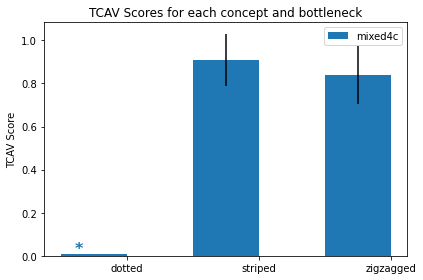

In [16]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)